# Чек-лист day02

## Основные баллы

 При проверке задания следует уделить внимание следующим вопросам:
1. Пропущенные значения заполнены:
    - 2020-11-13 - 0 (дождя не было);
    - 2020-11-14 и 2020-11-15 - 1 (дождь был).
2. Классификатор на основе логистической регрессии построен, на выборке 15 дней значение $F_1\ge0.86$.
3. Классификатор на основе дерева решений построен, на выборке 15 дней значение $F_1\ge0.9$.
4. Классификатор на основе метода ближайших соседей построен, на выборке 15 дней значение $F_1\ge0.89$.
5. Проведен анализ по изменению классификатора на основе дерева решений при изменении параметра max_depth.
6. Проведен анализ по изменению классификатора на основе метода ближайших соседей при изменении параметра n_neighbors.

## Дополнительные баллы:
1. Метрика $F_1>0.86$ для логистической регрессии;
2. Метрика $F_1>0.9$ для дерева решений;
3. Метрика $F_1>0.89$ для метода ближайших соседей.


## Пример решения:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta, date, time
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from IPython.core.display import Image, display
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
import pylab
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 10)

In [2]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [3]:
def share_date_time(df, sep = ' '):
    X = df.Order_date_time.str.split(pat = sep, expand = True)
    df['Order_date'], df['Order_time'] = X[0], X[1]
    return df

def day_of_the_week(df):
    df['day_of_the_week'] = [datetime.isoweekday(datetime.strptime(j, '%Y-%m-%d %H:%M:%S')) 
                             for j in df.Order_date_time]
    return df

def time_to_sec(df):
    df['Order_time_sec'] = pd.to_timedelta(df.Order_time)//np.timedelta64(1,'s')
    return df

def day_to_day(df):
    for i,j in enumerate(weekday):
        df[j] = [1 if d == i+1 else 0 for d in df.day_of_the_week]
    return df

def data_to_sin_cos(df):
    df['weekday_sin'] = np.sin(df.day_of_the_week*math.pi*2/7)
    df['weekday_cos'] = np.cos(df.day_of_the_week*math.pi*2/7)
    df['Order_sin'] = np.sin(df.Order_time_sec*math.pi/43200)
    df['Order_cos'] = np.cos(df.Order_time_sec*math.pi/43200)
    return df

df = pd.read_excel('iCafe 2 month.xlsx')
df_15 = pd.read_excel('iCafe 15 days.xlsx')
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df = share_date_time(df)
df_15 = share_date_time(df_15)
df = day_of_the_week(df)
df_15 = day_of_the_week(df_15)
df = time_to_sec(df)
df_15 = time_to_sec(df_15)
df = day_to_day(df)
df_15 = day_to_day(df_15)
df = data_to_sin_cos(df)
df_15 = data_to_sin_cos(df_15)

In [4]:
"""Заполнение пропущенных значений"""

df_15[df.Order_date == '2020-11-13'].fillna(0, inplace = True) # 13 ноября дождя не было
df_15.fillna(1, inplace = True)                                # В остальный дни дождь был

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


## Логистическая регрессия

In [5]:
def calculation_lr(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    lr = LogisticRegression(random_state=21)
    lr.fit(X_train_std, y_train)
    y_pred = lr.predict(X_test_std)
    print('Test')
    print(classification_report(y_test, y_pred))
    return sc, lr

def result(sc, clf, name, X, y):
    y_pred = clf.predict(sc.transform(X))
    print(name)
    print(classification_report(y, y_pred))
    return y_pred

s = ['weekday_sin', 'weekday_cos', 'Order_sin', 'Order_cos', 'Rain', 'Delivery_time']
y = df.Office
X = df[s]
sc_lr, clf_lr = calculation_lr(X, y)
df['Correct_lr'] = result(sc_lr, clf_lr, '2 month', X, y)

y = df_15.Office
X = df_15[s]
result(sc_lr, clf_lr, '15 days', X, y)

Test
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2332
           1       0.88      0.88      0.88      2866

    accuracy                           0.87      5198
   macro avg       0.87      0.87      0.87      5198
weighted avg       0.87      0.87      0.87      5198

2 month
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      9389
           1       0.88      0.88      0.88     11402

    accuracy                           0.87     20791
   macro avg       0.87      0.87      0.87     20791
weighted avg       0.87      0.87      0.87     20791

15 days
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2767
           1       0.85      0.85      0.85      2706

    accuracy                           0.85      5473
   macro avg       0.85      0.85      0.85      5473
weighted avg       0.85      0.85      0.85      5473

array([1, 0, 1, ..., 0, 1, 0])

In [6]:
s = ['Delivery_time', 'Rain', 'Order_sin', 'Order_cos', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
     'Saturday', 'Sunday']
y = df.Office
X = df[s]
sc_lr, clf_lr = calculation_lr(X, y)
df['Correct_lr'] = result(sc_lr, clf_lr, '2 month', X, y)

y = df_15.Office
X = df_15[s]
result(sc_lr, clf_lr, '15 days', X, y)

Test
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2332
           1       0.88      0.88      0.88      2866

    accuracy                           0.87      5198
   macro avg       0.87      0.87      0.87      5198
weighted avg       0.87      0.87      0.87      5198

2 month
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      9389
           1       0.88      0.89      0.88     11402

    accuracy                           0.87     20791
   macro avg       0.87      0.87      0.87     20791
weighted avg       0.87      0.87      0.87     20791

15 days
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2767
           1       0.86      0.85      0.85      2706

    accuracy                           0.86      5473
   macro avg       0.86      0.86      0.86      5473
weighted avg       0.86      0.86      0.86      5473

array([1, 0, 0, ..., 0, 1, 0])

## Дерево решений

Test
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2332
           1       0.96      0.87      0.91      2866

    accuracy                           0.91      5198
   macro avg       0.91      0.91      0.91      5198
weighted avg       0.91      0.91      0.91      5198

2 month
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      9389
           1       0.95      0.87      0.91     11402

    accuracy                           0.91     20791
   macro avg       0.91      0.91      0.91     20791
weighted avg       0.91      0.91      0.91     20791



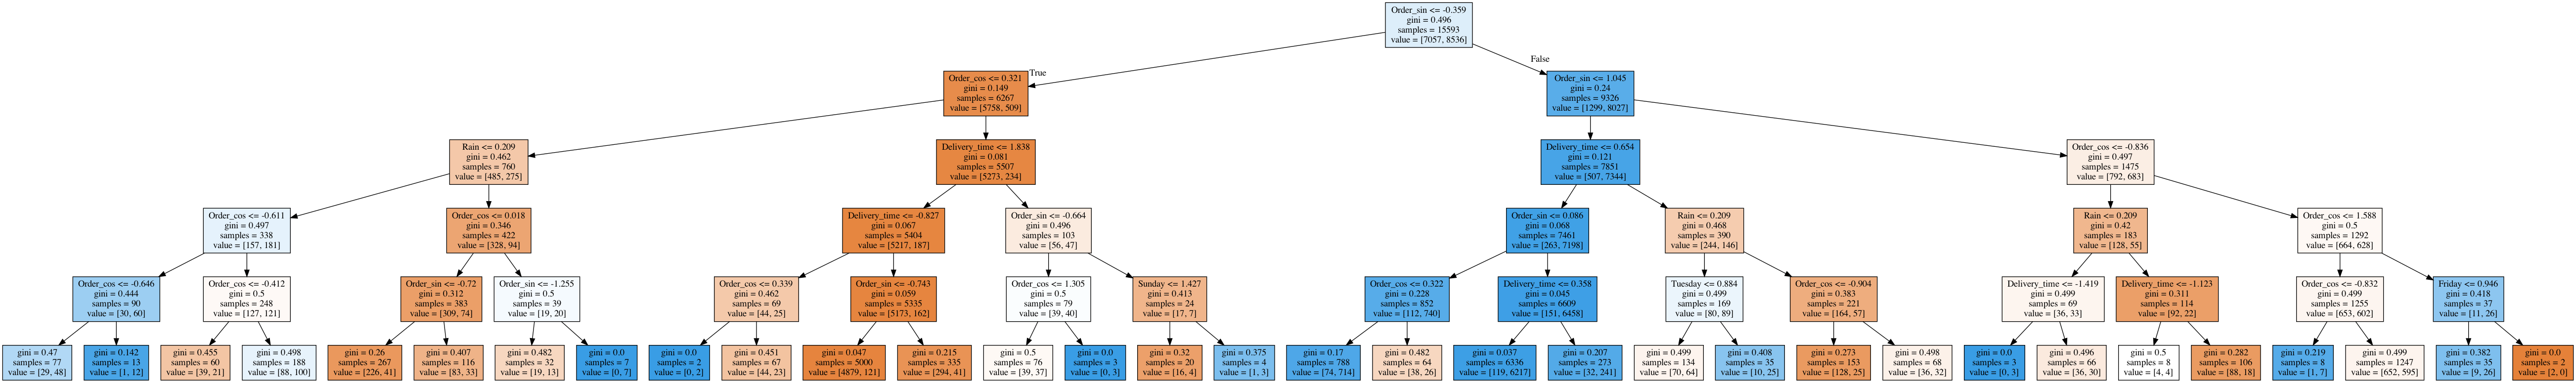

15 days
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2767
           1       0.94      0.84      0.89      2706

    accuracy                           0.90      5473
   macro avg       0.90      0.90      0.90      5473
weighted avg       0.90      0.90      0.90      5473



array([1, 0, 1, ..., 1, 1, 1])

In [7]:
def calculation_tree(X, y, maxdept):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    tree = DecisionTreeClassifier(random_state=21,max_depth=maxdept)
    tree.fit(X_train_std, y_train)
    y_pred = tree.predict(X_test_std)
    print('Test')
    print(classification_report(y_test, y_pred))
    return sc, tree

def tree_viz(tree, s):
    export_graphviz(tree, feature_names=s , out_file='tree.dot', filled=True)
    !dot -Tpng 'tree.dot' -o 'tree.png'
    display(Image('tree.png', unconfined=True))

s = ['Delivery_time', 'Rain', 'Order_sin', 'Order_cos', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
     'Saturday', 'Sunday']
y = df.Office
X = df[s]
sc_tree, clf_tree = calculation_tree(X, y, 5)
df['Correct_tree'] = result(sc_tree, clf_tree, '2 month', X, y)
tree_viz(clf_tree, s)

y = df_15.Office
X = df_15[s]
result(sc_tree, clf_tree, '15 days', X, y)

Test
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2332
           1       0.96      0.88      0.92      2866

    accuracy                           0.91      5198
   macro avg       0.91      0.92      0.91      5198
weighted avg       0.92      0.91      0.91      5198

2 month
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      9389
           1       0.95      0.87      0.91     11402

    accuracy                           0.91     20791
   macro avg       0.91      0.91      0.91     20791
weighted avg       0.91      0.91      0.91     20791



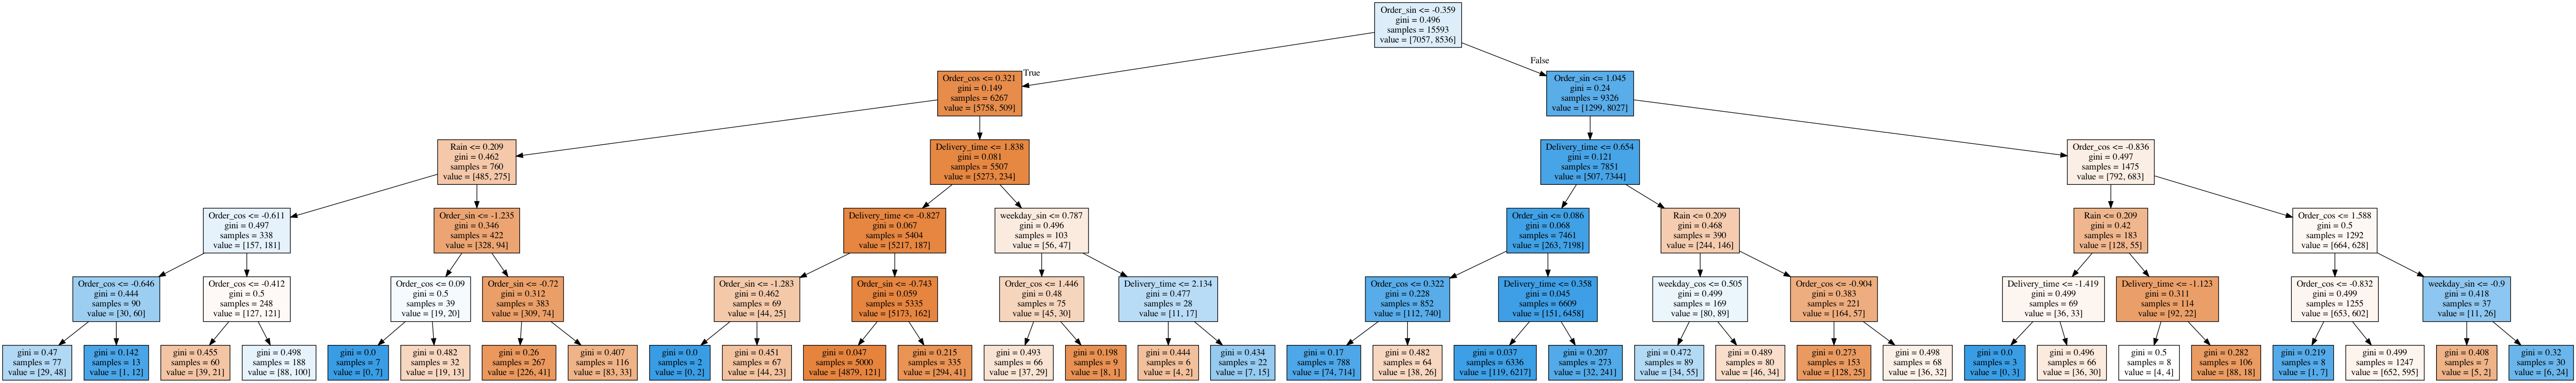

15 days
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2767
           1       0.94      0.85      0.89      2706

    accuracy                           0.90      5473
   macro avg       0.90      0.90      0.90      5473
weighted avg       0.90      0.90      0.90      5473



array([1, 0, 1, ..., 1, 1, 1])

In [8]:
s = ['Delivery_time', 'Rain', 'weekday_sin', 'weekday_cos', 'Order_sin', 'Order_cos']
y = df.Office
X = df[s]
sc_tree, clf_tree = calculation_tree(X, y, 5)
df['Correct_tree_2'] = result(sc_tree, clf_tree, '2 month', X, y)
tree_viz(clf_tree, s)
y = df_15.Office
X = df_15[s]
result(sc_tree, clf_tree, '15 days', X, y)

## Метод ближайших соседей

In [9]:
def calculation_knn(X, y, n=5):
    print('Количество соседей равно', n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_std, y_train)
    y_pred = knn.predict(X_test_std)
    print('Test n='+str(n))
    print(classification_report(y_test, y_pred))
    return sc, knn

s = ['weekday_sin', 'weekday_cos', 'Order_sin', 'Order_cos', 'Rain', 'Delivery_time']
y = df.Office
X = df[s]
yy = df_15.Office
XX = df_15[s]
for j in range(3,9):
    sc_knn, clf_knn = calculation_knn(X, y, j)
    df['Correct_knn_'+str(j)] = result(sc_knn, clf_knn, '2 month n='+str(j), X, y)
    result(sc_knn, clf_knn, '15 days n='+str(j), XX, yy)

Количество соседей равно 3
Test n=3
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2332
           1       0.91      0.90      0.90      2866

    accuracy                           0.90      5198
   macro avg       0.89      0.89      0.89      5198
weighted avg       0.90      0.90      0.90      5198

2 month n=3
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      9389
           1       0.93      0.92      0.93     11402

    accuracy                           0.92     20791
   macro avg       0.92      0.92      0.92     20791
weighted avg       0.92      0.92      0.92     20791

15 days n=3
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2767
           1       0.89      0.88      0.89      2706

    accuracy                           0.89      5473
   macro avg       0.89      0.89      0.89      5473
weighted avg  

In [10]:
s = ['Delivery_time', 'Rain', 'Order_sin', 'Order_cos', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
     'Saturday', 'Sunday']
y = df.Office
X = df[s]
yy = df_15.Office
XX = df_15[s]
for j in range(3,9):
    sc_knn, clf_knn = calculation_knn(X, y, j)
    df['Correct_knn_'+str(j)] = result(sc_knn, clf_knn, '2 month n='+str(j), X, y)
    result(sc_knn, clf_knn, '15 days n='+str(j), XX, yy)

Количество соседей равно 3
Test n=3
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2332
           1       0.91      0.90      0.90      2866

    accuracy                           0.90      5198
   macro avg       0.89      0.89      0.89      5198
weighted avg       0.90      0.90      0.90      5198

2 month n=3
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      9389
           1       0.93      0.92      0.93     11402

    accuracy                           0.92     20791
   macro avg       0.92      0.92      0.92     20791
weighted avg       0.92      0.92      0.92     20791

15 days n=3
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      2767
           1       0.89      0.88      0.89      2706

    accuracy                           0.89      5473
   macro avg       0.89      0.89      0.89      5473
weighted avg  